<font color='red'>WARNING-1: No se aceptan soluciones que usen metodologías distintas a las vistas en clases.</font>

<font color='orange'>Está permitido usar los códigos de los ejemplos vistos en clases.</font>



# Segmentación de Pulmones usando UNet



# 0) Cambiar el nombre del archivo

<font color='red'>WARNING-2: CAMBIA EL NOMBRE DEL ARCHIVO ipynb INCLUYENDO TU RUT</font>

Ejemplo, si tu RUT es 12.345.678-9, el nombre de este archivo debe cambiarse de "E08_Tu_Rut.ipynb" a "E08_12345678-9.ipynb"


# 1) Importe las Librerías

(1 Punto)

Importe las librerías y definia la variable `device` según el ejemplo visto en clases.

*Todas las librerías de este código deben ir en esta celda. Sólo está permitido usar las librerías de los ejemplos vistos en clase.*



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from   torch.utils.data import Dataset, DataLoader
from   torchvision import datasets, models, transforms
from   skimage.color import label2rgb
import matplotlib.pyplot as plt
import numpy as np
import cv2
import fnmatch
import os

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device:', device) 

Device: cuda


# 2) Descarga de Base de Datos

(1 Punto)

Descargue las imágenes y sus segmentaciones ideales de `https://www.dropbox.com/s/qgvmtkulrtdwa1j/project.zip`


In [2]:
!wget https://www.dropbox.com/s/qgvmtkulrtdwa1j/project.zip
!unzip -qq project.zip

--2022-10-25 01:10:46--  https://www.dropbox.com/s/qgvmtkulrtdwa1j/project.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/qgvmtkulrtdwa1j/project.zip [following]
--2022-10-25 01:10:47--  https://www.dropbox.com/s/raw/qgvmtkulrtdwa1j/project.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccf7d9fef2e94838b5547f604a4.dl.dropboxusercontent.com/cd/0/inline/Bve7uWbQmYpwagzn6i0szKjsJ1gb9L3E-RCRSEP5AW-FX7fzewbv3yRWNySNEjt030TYJbRuYUdQAv58_lbsaz5-nBU4y5Uuxv4DOmz-8EyMd7zyeHMkZSNZQCQ4fgDsvqhAfneHK4V18on6zwNfL0kDBAtAYzNnNjUNJ87YNlY9vg/file# [following]
--2022-10-25 01:10:47--  https://uccf7d9fef2e94838b5547f604a4.dl.dropboxusercontent.com/cd/0/inline/Bve7uWbQmYpwagzn6i0szKjsJ1gb9L3E-RCRSEP5AW-FX7fzewbv3yRWNySNEjt030TYJbRuYUdQAv58_

# 3) Data Augmentation

(2 puntos)

* Copie la carpeta `project/images` en `project\imgplus` 

* Copie la carpeta `project/segmentation` en `project\segplus`

* "Flipee" verticalmente las primeras 30 imágenes de `project\imgplus` (para generar un versión espejo) y guárdelas en `project\imgplus` como `A0001.png` ... `A0030.png`.

* "Flipee" verticalmente las primeras 30 imágenes de `project\segplus` (para generar un versión espejo) y guárdelas en `project\segplus` como `B0001.png` ... `B0030.png`.

Para "flipear" use  la función `cv2.flip`





In [3]:
!cp -av 'project/images' 'project\imgplus'
!cp -av 'project/segmentation' 'project\segplus'

'project/images' -> 'project\imgplus'
'project/images/.DS_Store' -> 'project\imgplus/.DS_Store'
'project/images/X0007.png' -> 'project\imgplus/X0007.png'
'project/images/X0013.png' -> 'project\imgplus/X0013.png'
'project/images/X0012.png' -> 'project\imgplus/X0012.png'
'project/images/X0006.png' -> 'project\imgplus/X0006.png'
'project/images/X0038.png' -> 'project\imgplus/X0038.png'
'project/images/X0010.png' -> 'project\imgplus/X0010.png'
'project/images/X0004.png' -> 'project\imgplus/X0004.png'
'project/images/X0005.png' -> 'project\imgplus/X0005.png'
'project/images/X0011.png' -> 'project\imgplus/X0011.png'
'project/images/X0039.png' -> 'project\imgplus/X0039.png'
'project/images/X0015.png' -> 'project\imgplus/X0015.png'
'project/images/X0001.png' -> 'project\imgplus/X0001.png'
'project/images/X0029.png' -> 'project\imgplus/X0029.png'
'project/images/X0028.png' -> 'project\imgplus/X0028.png'
'project/images/X0014.png' -> 'project\imgplus/X0014.png'
'project/images/X0002.png' -> 'pro

In [4]:
#project\imgplus
names_imgplus = sorted(os.listdir('/content/project\imgplus'))[1:31]
names_seg_plus = sorted(os.listdir('/content/project\segplus'))[1:31]

for name in names_imgplus:
  img = cv2.flip(cv2.imread('/content/project\imgplus/' + name),0)
  n = names_imgplus.index(name)+1
  cv2.imwrite('/content/project\imgplus/A' + str(n).zfill(4) + '.png', img)

#project\segplus
for name in names_seg_plus:
  img = cv2.flip(cv2.imread('/content/project\segplus/' + name),0)
  n = names_seg_plus.index(name)+1
  cv2.imwrite('/content/project\segplus/B' + str(n).zfill(4) + '.png', img)

# 4) Definición de arquitectura UNET y funciones necesarias

(1 punto)

A partir del código visto en clases como ejemplo, en las próximas celdas incluya  las siguientes funciones y clases:

* Clase `Unet` (primera implementación)

* Función `train_epoch`

* Función `eval_epoch`

* Función `num_trainable_parameters`

* Función `show_history`

* Función `load_images`

* Función `regionview`

* Función `num2fixstr`

* Clase `UnetDataset`

In [5]:
class Unet(nn.Module):

    def __init__(self, n, batch_size=50):

        super().__init__()
        
        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=n, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=n, out_channels=n, kernel_size=3, padding='same'),
            nn.ReLU(),
        )

        self.conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=n, out_channels=2*n, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=2*n, out_channels=2*n, kernel_size=3, padding='same'),
            nn.ReLU(),
        )

        self.conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=2*n, out_channels=4*n, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=4*n, out_channels=4*n, kernel_size=3, padding='same'),
            nn.ReLU(),
        )

        self.conv_4 = nn.Sequential(
            nn.Conv2d(in_channels=4*n, out_channels=8*n, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=8*n, out_channels=8*n, kernel_size=3, padding='same'),
            nn.ReLU(),
        )

        self.conv_5 = nn.Sequential(
            nn.Conv2d(in_channels=8*n, out_channels=16*n, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=16*n, out_channels=16*n, kernel_size=3, padding='same'),
            nn.ReLU(),
        )

        self.conv_6 = nn.Sequential(
            nn.Conv2d(in_channels=16*n, out_channels=8*n, kernel_size=3, padding='same'),
            nn.ReLU(), 
            nn.Conv2d(in_channels=8*n, out_channels=8*n, kernel_size=3, padding='same'),
            nn.ReLU()
        )

        self.conv_7 = nn.Sequential(
            nn.Conv2d(in_channels=8*n, out_channels=4*n, kernel_size=3, padding='same'),
            nn.ReLU(), 
            nn.Conv2d(in_channels=4*n, out_channels=4*n, kernel_size=3, padding='same'),
            nn.ReLU()
        )

        self.conv_8 = nn.Sequential(
            nn.Conv2d(in_channels=4*n, out_channels=2*n, kernel_size=3, padding='same'),
            nn.ReLU(), 
            nn.Conv2d(in_channels=2*n, out_channels=2*n, kernel_size=3, padding='same'),
            nn.ReLU()
        )

        self.conv_9 = nn.Sequential(
            nn.Conv2d(in_channels=2*n, out_channels=n, kernel_size=3, padding='same'),
            nn.ReLU(), 
            nn.Conv2d(in_channels=n, out_channels=n, kernel_size=3, padding='same'),
            nn.ReLU()
        )

        self.conv_A = nn.Sequential(
            nn.Conv2d(in_channels=n, out_channels=1, kernel_size=1, padding='same'),
            nn.Sigmoid()
        )

        self.up_6 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=16*n, out_channels=8*n, kernel_size=2, padding='same'),
            nn.ReLU()
        )

        self.up_7 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=8*n, out_channels=4*n, kernel_size=2, padding='same'),
            nn.ReLU()
        )

        self.up_8 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=4*n, out_channels=2*n, kernel_size=2, padding='same'),
            nn.ReLU()
        )

        self.up_9 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=2*n, out_channels=n, kernel_size=2, padding='same'),
            nn.ReLU()
        )

    def forward(self, input_):
        conv_1 = self.conv_1(input_)
        pool_1 = nn.MaxPool2d(kernel_size=(2,2))(conv_1)

        conv_2 = self.conv_2(pool_1)
        pool_2 = nn.MaxPool2d(kernel_size=(2,2))(conv_2)

        conv_3 = self.conv_3(pool_2)
        pool_3 = nn.MaxPool2d(kernel_size=(2,2))(conv_3)

        conv_4 = self.conv_4(pool_3)
        pool_4 = nn.MaxPool2d(kernel_size=(2,2))(conv_4)

        conv_5 = self.conv_5(pool_4)

        up_6    = self.up_6(conv_5)
        merge_6 = torch.cat([conv_4, up_6], dim=1)
        conv_6  = self.conv_6(merge_6)

        up_7    = self.up_7(conv_6)
        merge_7 = torch.cat([conv_3, up_7], dim=1)
        conv_7  = self.conv_7(merge_7)

        up_8    = self.up_8(conv_7)
        merge_8 = torch.cat([conv_2, up_8], dim=1)
        conv_8  = self.conv_8(merge_8)

        up_9    = self.up_9(conv_8)
        merge_9 = torch.cat([conv_1, up_9], dim=1)
        conv_9  = self.conv_9(merge_9)

        return self.conv_A(conv_9)

In [6]:
def train_epoch(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()

        img, seg = batch
        img = img.to(device)
        seg = seg.to(device)

        predictions = model(img)

        loss = criterion(predictions, seg)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    return epoch_loss/len(iterator)


def eval_epoch(model, iterator, criterion, device):
    
    #initialize every epoch
    epoch_loss = 0

    #deactivating dropout layers
    model.eval()

    #deactivates autograd
    with torch.no_grad():
        for batch in iterator:
        
            img, seg = batch
            img = img.to(device)
            seg = seg.to(device)
            
            #convert to 1d tensor
            predictions = model(img)
            
            #compute loss
            loss = criterion(predictions, seg)
            
            #keep track of loss
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def num_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def show_history(history):
    print(history.history.keys())
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Lectura de imágenes a color y segmentación para definir conjuntos
# de training, validación y testing

def load_images(img_names,seg_names, i1, i2, st, nl=32, nc=32, echo='off'):
    print('reading '+st+' ...')
    n     = i2 - i1
    AX    = np.empty((n, nl, nc), dtype='uint8')
    AY    = np.empty((n, nl, nc), dtype='uint8')
    t     = 0
    for t in range(n):
        i = i1 + t
        st = img_names[i]
        X = cv2.imread(st, 0)
        X = cv2.resize(X, (nl, nc))

        yt = seg_names[i]
        Y = cv2.imread(yt,0)
        Y = cv2.resize(Y,(nl,nc))

        if echo=='on':
            print('processing files '+st)
            print('processing files '+xt) 

        AX[t] = X
        AY[t] = Y
    ax    = np.float32(AX)/255.0
    ay    = np.float32(AY)/255.0 
    ax    = ax.reshape(n, 1, nl, nc)
    ay    = ay.reshape(n, 1, nl, nc)

    return ax, ay

def regionview(img, mask):
    img_color = np.dstack((img, img, img))
    img_color = label2rgb(mask, image=img_color, bg_label=0)
    return img_color

def dirfiles(img_path, img_ext,full=False):
    img_names = fnmatch.filter(sorted(os.listdir(img_path)),img_ext)
    if full:
      n = len(img_names)
      for i in range(n):
        img_names[i] = img_path+img_names[i]
    return img_names

def num2fixstr(x,d):
  # example num2fixstr(2,5) returns '00002'
  # example num2fixstr(19,3) returns '019'
  st = '%0*d' % (d,x)
  return st

In [7]:
class UnetDataset(Dataset):

    def __init__(self, img_x, img_y):
        super().__init__()
        self.img_x = img_x
        self.img_y = img_y

    def __len__(self):
        return len(self.img_x)

    def __getitem__(self, item):
        return torch.from_numpy(self.img_x[item]), torch.from_numpy(self.img_y[item])

def get_data_loader (img_x, img_y, transform=None, batch_size=10, num_workers=1):
    dt = UnetDataset(img_x, img_y)
    dl = DataLoader(dataset=dt, batch_size=batch_size, num_workers=num_workers)

    return dl

# 5) Definición de parámetros y modelo

(1 punto)

Usando el ejemplo visto en clases, para un entrenamiento con imágenes de 64x64 pixeles, un tamaño de batch de 10, defina el modelo Unet


In [8]:
n           = 64 # size of the Unet
batch_size  = 10
t           = torch.rand(batch_size, 1, n, n).to(device)
num_workers = 2


print(t.shape)

model       = Unet(n).to(device)
print(model(t).shape)

torch.Size([10, 1, 64, 64])
torch.Size([10, 1, 64, 64])


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:454: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:882.)
  self.padding, self.dilation, self.groups)


# 6) Definición de conjuntos de Training/Validation/Testing

(2 puntos)

Usando el ejemplo visto en clases:

* Defina para el entrenamiento las variables `ax,ay` con las primeras 62 imágenes y sus correspondientes 62 segmentaciones de la base de datos aumentada. 

* Defina para la validación las variables `vx,vy` con las siguientes 4 imágenes y sus correspondientes 4 segmentaciones de la base de datos aumentada. 

* Defina para las pruebas las variables `qx,qy` las últimas 4 imágenes y sus correspondientes 4 segmentaciones de la base de datos aumentada. 


In [9]:
# Definition of images' and segmentations' files
fpath = 'project'
ipath = fpath + '\imgplus/' # images
spath = fpath + '\segplus/'   # ideal segmentation
img_names = dirfiles(ipath, '*.png',full=True) # warning: seg_names[i] debe ser ...
seg_names = dirfiles(spath, '*.png',full=True) # la segmentacion de img_names[i] !!!

# Split: Train/Val/Testing
ax, ay = load_images(img_names,seg_names,   0, 62,'train', nl=n, nc=n)
vx, vy = load_images(img_names,seg_names, 62, 66,'val'  , nl=n, nc=n)
qx, qy = load_images(img_names,seg_names, 66, 70,'test' , nl=n, nc=n)

reading train ...
reading val ...
reading test ...


# 7) Definición de dataset y loaders

(1 punto)

Usando el ejemplo visto en clases defina

* el dataset y el loader para el entrenamiento y cárguelo en las variables `train_dataset` y `train_dataloader` respectivamente

* el dataset y el loader para la validación y cárguelo en las variables `val_dataset` y `val_dataloader` respectivamente


In [10]:
train_dataset    = UnetDataset(ax, ay)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_workers)

val_dataset      = UnetDataset(vx, vy)
val_dataloader   = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=num_workers)

# 8) Entrenamiento

(2 puntos)

Usando el ejemplo visto en clases, 

* entrene el modelo UNet con 50 épocas

* garfique la perdia del entrenamiento y de la validación de estas 50 épocas

In [11]:
lr        = 1e-4 # learning rate

device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

cuda


In [12]:
num_epochs      = 50

train_loss_hist = []
val_loss_hist   = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_dataloader, optimizer, criterion, device)
    train_loss_hist.append(train_loss)
    st = f'Training Loss: {train_loss:.4f}'
    val_loss = eval_epoch(model, val_dataloader, criterion, device)
    val_loss_hist.append(val_loss)
    sv = f'Validation Loss: {val_loss:.4f}'
    print('['+num2fixstr(epoch+1,3)+'/'+num2fixstr(num_epochs,3)+'] ' + st + ' | '+sv)


[001/050] Training Loss: 0.2294 | Validation Loss: 0.2284
[002/050] Training Loss: 0.2219 | Validation Loss: 0.2192
[003/050] Training Loss: 0.2027 | Validation Loss: 0.2206
[004/050] Training Loss: 0.1851 | Validation Loss: 0.1921
[005/050] Training Loss: 0.1742 | Validation Loss: 0.1901
[006/050] Training Loss: 0.1700 | Validation Loss: 0.1844
[007/050] Training Loss: 0.1646 | Validation Loss: 0.1787
[008/050] Training Loss: 0.1552 | Validation Loss: 0.1651
[009/050] Training Loss: 0.1368 | Validation Loss: 0.1357
[010/050] Training Loss: 0.1112 | Validation Loss: 0.1263
[011/050] Training Loss: 0.1055 | Validation Loss: 0.1065
[012/050] Training Loss: 0.0927 | Validation Loss: 0.0965
[013/050] Training Loss: 0.0891 | Validation Loss: 0.0975
[014/050] Training Loss: 0.0908 | Validation Loss: 0.1101
[015/050] Training Loss: 0.0938 | Validation Loss: 0.0925
[016/050] Training Loss: 0.0825 | Validation Loss: 0.0882
[017/050] Training Loss: 0.0757 | Validation Loss: 0.0806
[018/050] Trai

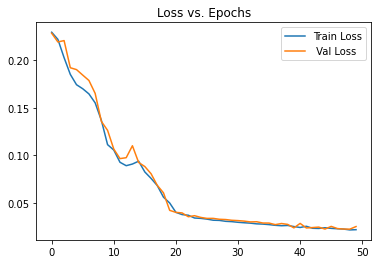

In [13]:
plt.plot(train_loss_hist,label='Train Loss')
plt.plot(val_loss_hist,label=' Val Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.show()

# 9) Prueba del algoritmo: Precision y Recall en el Testing

(2 puntos) 

Usando el ejemplo visto en clases, calcule Precision y Recall en las imágenes de Testing



In [14]:
def unet_segmentation(I,model,nl=32,nc=32,show=0):
    J     = I.astype(float)
    (N,M) = J.shape
    jmax  = np.max(J)
    jmin  = np.min(J)
    J     = (J-jmin)/(jmax-jmin)
    QX    = cv2.resize(J,(nc,nl))
    qx    = np.float32(QX)
    qx    = qx.reshape(1,nl,nc,1)
    qx    = np.swapaxes(qx, 1, 3)
    qx    = np.swapaxes(qx, 2, 3)

    qx    = torch.from_numpy(qx).to(device)
    model.eval()
    qp    = model(qx)
    qp    = qp.cpu().detach().numpy()
    qp    = qp.reshape(nl,nc)
    QPB   = np.zeros((nl,nc),dtype='uint8')
    QPB[ qp>=0.5 ] = 255

    if show:
        f = plt.figure()
        f.add_subplot(1,2,1); plt.imshow(QX,cmap="gray"); plt.axis('off')
        f.add_subplot(1,2,2); plt.imshow(QPB,cmap="gray"); plt.axis('off')
        plt.show(block=True)

    R = cv2.resize(QPB,(M,N))>128

    return R

In [15]:
TP = 0
FP = 0
FN = 0
for i in range(qx.shape[0]):
  X  = qx[i,0,:,:]
  GT = qy[i,0,:,:]
  D  = unet_segmentation(X, model, nl=n, nc=n)
  TP = TP + np.sum(np.multiply(D==1,GT==1))
  FP = FP + np.sum(np.multiply(D==1,GT==0))
  FN = FN + np.sum(np.multiply(D==0,GT==1))
Pr = TP/(TP+FP)
Re = TP/(TP+FN)

print('Testing:')
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')


Testing:
Precision = 0.9499
Recall    = 0.9354


# 10) Segmentación de imagen de pruebas

(1 punto)

Usando el ejemplo visto en clases, grafique la segmentación ideal, y la obtenida de Unet de la imagen de testing `X0039.png`

processing file project\imgplus/X0039.png


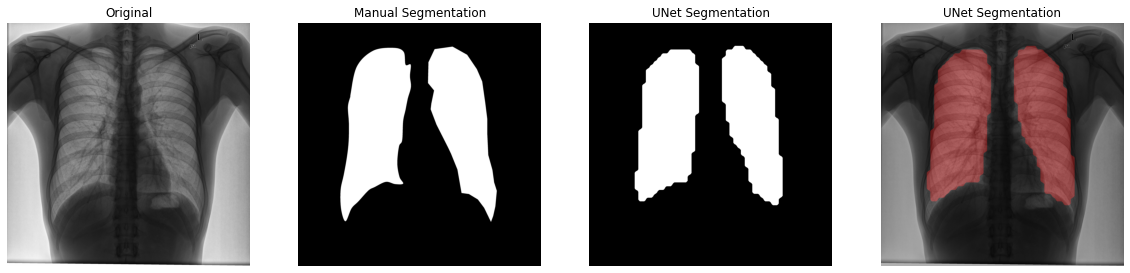

In [16]:
i =  img_names.index('project\\imgplus/X0039.png') # <= Ingrese aqui imagen de testing 
# Input: Color Image
st = img_names[i]
print('processing file '+st)
img0 = cv2.cvtColor(cv2.imread(st), cv2.COLOR_BGR2RGB)

# Manual Segmentation
xt = seg_names[i]
Ri = cv2.cvtColor(cv2.imread(xt), cv2.COLOR_BGR2RGB)

# UNet Segmentation
img   = cv2.cvtColor(img0, cv2.COLOR_RGB2GRAY)
R     = unet_segmentation(img, model,nl=n, nc=n)
imgs  = regionview(img,R)

# Output
f = plt.figure(figsize=(20,6))

f.add_subplot(1,4,1); plt.imshow(img0); plt.axis('off'); plt.title('Original')
f.add_subplot(1,4,2); plt.imshow(Ri); plt.axis('off'); plt.title('Manual Segmentation')
f.add_subplot(1,4,3); plt.imshow(R,cmap="gray"); plt.axis('off'); plt.title('UNet Segmentation')
f.add_subplot(1,4,4); plt.imshow(imgs); plt.axis('off'); plt.title('UNet Segmentation')
plt.show()

# 11) Entrenamiento sin Data Augmentation

(3 puntos)

En las siguientes celdas, escriba un código que 

* entrene UNet usando la base de datos original (sin Data Augmentation, usando las primeras 32 imágenes de training, las siguientes 4 de validation, y las últimas 4 de testing)

* calcule el precision y recall en el testing

* grafique la segmentación ideal, y la obtenida de Unet de la imagen de testing X0039.png

In [17]:
# Definition of images' and segmentations' files
fpath = 'project/'
ipath = fpath + 'images/' # images
spath = fpath + 'segmentation/'   # ideal segmentation
img_names = dirfiles(ipath, '*.png',full=True) # warning: seg_names[i] debe ser ...
seg_names = dirfiles(spath, '*.png',full=True) # la segmentacion de img_names[i] !!!

# Split: Train/Val/Testing
ax, ay = load_images(img_names,seg_names,   0, 32,'train', nl=n, nc=n)
vx, vy = load_images(img_names,seg_names, 32, 36,'val'  , nl=n, nc=n)
qx, qy = load_images(img_names,seg_names, 36, 40,'test' , nl=n, nc=n)

reading train ...
reading val ...
reading test ...


In [18]:
train_dataset    = UnetDataset(ax, ay)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_workers)

val_dataset      = UnetDataset(vx, vy)
val_dataloader   = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=num_workers)

In [19]:
lr        = 1e-4 # learning rate

device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

cuda


In [20]:
num_epochs      = 50

train_loss_hist = []
val_loss_hist   = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_dataloader, optimizer, criterion, device)
    train_loss_hist.append(train_loss)
    st = f'Training Loss: {train_loss:.4f}'
    val_loss = eval_epoch(model, val_dataloader, criterion, device)
    val_loss_hist.append(val_loss)
    sv = f'Validation Loss: {val_loss:.4f}'
    print('['+num2fixstr(epoch+1,3)+'/'+num2fixstr(num_epochs,3)+'] ' + st + ' | '+sv)

[001/050] Training Loss: 0.0760 | Validation Loss: 0.0846
[002/050] Training Loss: 0.0539 | Validation Loss: 0.0361
[003/050] Training Loss: 0.0431 | Validation Loss: 0.0433
[004/050] Training Loss: 0.0367 | Validation Loss: 0.0430
[005/050] Training Loss: 0.0368 | Validation Loss: 0.0400
[006/050] Training Loss: 0.0315 | Validation Loss: 0.0287
[007/050] Training Loss: 0.0285 | Validation Loss: 0.0265
[008/050] Training Loss: 0.0260 | Validation Loss: 0.0259
[009/050] Training Loss: 0.0243 | Validation Loss: 0.0275
[010/050] Training Loss: 0.0231 | Validation Loss: 0.0270
[011/050] Training Loss: 0.0219 | Validation Loss: 0.0251
[012/050] Training Loss: 0.0212 | Validation Loss: 0.0235
[013/050] Training Loss: 0.0205 | Validation Loss: 0.0229
[014/050] Training Loss: 0.0200 | Validation Loss: 0.0222
[015/050] Training Loss: 0.0195 | Validation Loss: 0.0218
[016/050] Training Loss: 0.0191 | Validation Loss: 0.0209
[017/050] Training Loss: 0.0188 | Validation Loss: 0.0209
[018/050] Trai

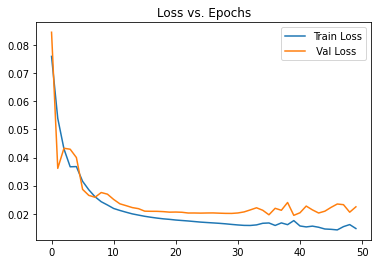

In [21]:
plt.plot(train_loss_hist,label='Train Loss')
plt.plot(val_loss_hist,label=' Val Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.show()

In [22]:
TP = 0
FP = 0
FN = 0
for i in range(qx.shape[0]):
  X  = qx[i,0,:,:]
  GT = qy[i,0,:,:]
  D  = unet_segmentation(X, model, nl=n, nc=n)
  TP = TP + np.sum(np.multiply(D==1,GT==1))
  FP = FP + np.sum(np.multiply(D==1,GT==0))
  FN = FN + np.sum(np.multiply(D==0,GT==1))
Pr = TP/(TP+FP)
Re = TP/(TP+FN)

print('Testing:')
print(f'Precision = {Pr:.4f}')
print(f'Recall    = {Re:.4f}')

Testing:
Precision = 0.8735
Recall    = 0.9772


processing file project/images/X0039.png


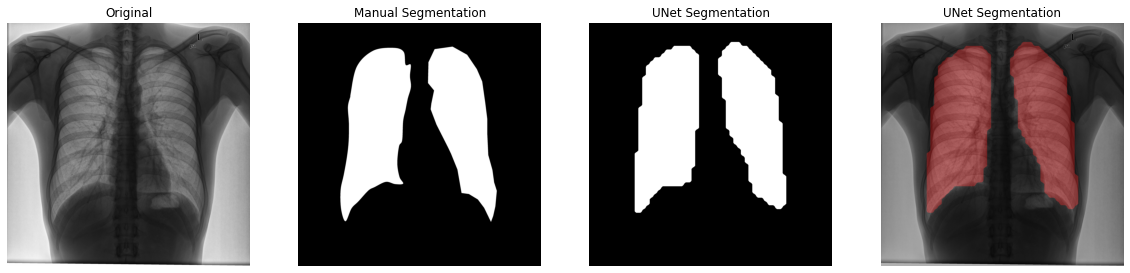

In [23]:
i =  img_names.index('project/images/X0039.png') # <= Ingrese aqui imagen de testing 
# Input: Color Image
st = img_names[i]
print('processing file '+st)
img0 = cv2.cvtColor(cv2.imread(st), cv2.COLOR_BGR2RGB)

# Manual Segmentation
xt = seg_names[i]
Ri = cv2.cvtColor(cv2.imread(xt), cv2.COLOR_BGR2RGB)

# UNet Segmentation
img   = cv2.cvtColor(img0, cv2.COLOR_RGB2GRAY)
R     = unet_segmentation(img, model,nl=n, nc=n)
imgs  = regionview(img,R)

# Output
f = plt.figure(figsize=(20,6))

f.add_subplot(1,4,1); plt.imshow(img0); plt.axis('off'); plt.title('Original')
f.add_subplot(1,4,2); plt.imshow(Ri); plt.axis('off'); plt.title('Manual Segmentation')
f.add_subplot(1,4,3); plt.imshow(R,cmap="gray"); plt.axis('off'); plt.title('UNet Segmentation')
f.add_subplot(1,4,4); plt.imshow(imgs); plt.axis('off'); plt.title('UNet Segmentation')
plt.show()

# <font color='red'>SUBA EL COLAB A CANVAS</font>


